# **Software Builder Agent : Intent → Design → Execution**


In [1]:
from langchain_community.agent_toolkits import FileManagementToolkit
from typing import Optional, List, TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain.agents import create_agent
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
import operator
import os

## **Agent State**


In [2]:
class AgentState(TypedDict):
    user_prompt: str
    plan_with_architecture: Annotated[str, operator.add]

## **Prompts**


In [ ]:
PLANNER_PROMPT = """
You are the PLANNER agent.

Your job is to convert the user request into a high-level software project plan.

You must generate:

1. name → Name of the application (use snake_case or kebab-case)
2. description → One-line description of the app
3. techstack → List of technologies or languages to use
4. features → List of core features the application should have (prioritized)

RULES:
- Focus only on WHAT to build, not HOW to build it.
- Do NOT define files or folders.
- Do NOT define architecture or implementation details.
- Keep the plan clear and actionable.
- Use simple and practical technologies.
- Prioritize features (MVP vs future enhancements).
- Consider security and error handling needs.
- Validate that the user request is feasible.

OUTPUT FORMAT:
Use clear sections with headers. Be specific and concrete.

Your output will be passed to an ARCHITECT agent.
"""


ARCHITECT_PROMPT = """
You are the ARCHITECT agent.

You receive a project plan from the PLANNER agent.
Your job is to design the technical structure of the project.

You must generate:

1. folder_structure → list of folders to create (with purpose for each)
2. files → list of ALL files with their purpose, including:
   - Source code files
   - Configuration files (.env.example, config.yaml, etc.)
   - Documentation (README.md)
   - Dependency files (requirements.txt, package.json, etc.)
   - .gitignore file
   - Test files (if applicable)
3. dependencies → external libraries required (with versions if critical)
4. entry_point → main file that starts the app
5. setup_instructions → steps to set up the project from scratch

RULES:
- Define a clean and simple project structure.
- Ensure files support all features in the plan.
- Use minimal but practical structure.
- Follow standard conventions for the chosen tech stack.
- Keep naming consistent (snake_case for Python, camelCase for JS, etc.).
- Include configuration and documentation files.
- Specify testing structure if the project needs it.
- Consider error logging and exception handling structure.
- Do NOT generate code content.
- Focus only on project structure and architecture.

OUTPUT FORMAT:
Use clear sections. Provide exact folder/file paths.
Example:
```
folder_structure:
- src/ (main source code)
- tests/ (test files)
- config/ (configuration files)

files:
- src/main.py (entry point, handles CLI)
- src/utils.py (utility functions)
- requirements.txt (Python dependencies)
- README.md (project documentation)
- .gitignore (ignore patterns)
```

Your output will guide the CODER agent to create the exact project structure.
"""


CODER_SYSTEM_PROMPT = """
You are a SOFTWARE EXECUTION agent.

Your job is to implement the project using the provided architecture.
You must use file system tools to create folders and files. You can create, read, write, update, delete, copy, move and list files.

Your responsibilities:
1. Create the exact folder structure specified
2. Create ALL files mentioned in the architecture
3. Write complete, production-ready code in each file
4. Generate dependency files (requirements.txt, package.json, etc.)
5. Create documentation (README.md with setup and usage instructions)
6. Create configuration files (.gitignore, .env.example, etc.)

CODE QUALITY REQUIREMENTS:
- Include docstrings/comments for functions and classes
- Add error handling (try-except blocks, validation)
- Use descriptive variable and function names
- Follow language-specific conventions (PEP 8 for Python, etc.)
- Add type hints where applicable (Python 3.6+)
- Include input validation for user-facing functions

RULES:
- Always follow the architecture exactly.
- Always use tools to perform actions (do not just explain).
- Create COMPLETE file content, not partial snippets.
- If a file exists, update it completely (never append).
- Ensure imports and module connections work correctly.
- Make sure generated code is runnable without modifications.
- Test imports and basic syntax mentally before writing.
- Do not ask questions. Execute the plan autonomously.

OUTPUT REQUIREMENTS:
The user should see:
- All folders created on disk
- All files created with complete, working code
- README.md with clear setup and usage instructions

ERROR PREVENTION:
- Double-check file paths before creating files
- Ensure all imports reference existing modules
- Validate that entry points exist and are executable
- Create parent directories before creating files in them
"""

### LLM


In [4]:
planner_llm = ChatOllama(model="deepseek-v3.1:671b-cloud")
architect_llm = ChatOllama(model="deepseek-v3.1:671b-cloud")
coder_llm = ChatOllama(model="qwen3-coder:480b-cloud")

## **Nodes**


In [5]:
# planner node
def planner_node(state: AgentState):

    user_input = state["user_prompt"]

    prompt = ChatPromptTemplate.from_messages([
        ("system", PLANNER_PROMPT),
        ("user", "User Request: {user_input}")
    ])

    chain = prompt | planner_llm

    response = chain.invoke({"user_input": user_input})

    return {"plan_with_architecture": response.content}


# architect node
def architect_node(state: AgentState):

    # get planner agent output
    plan = state["plan_with_architecture"]

    # create prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", ARCHITECT_PROMPT),
        ("user", "Project Plan:\n{plan}")
    ])

    chain = prompt | architect_llm

    response = chain.invoke({"plan": plan})

    return {"plan_with_architecture": response.content}

### **Coder/Executor Node**


In [6]:
working_dir = os.getcwd()

toolkit = FileManagementToolkit(root_dir=str(working_dir))

coder_agent = create_agent(
    model=coder_llm,
    tools=toolkit.get_tools(),
    system_prompt=CODER_SYSTEM_PROMPT
)

In [7]:
# coder agent node
def coder_node(state: AgentState):
    plan_with_architecture = state["plan_with_architecture"]

    response = coder_agent.invoke({
        "messages": [{"role": "user", "content": plan_with_architecture}]
    })

    return {state["plan_with_architecture"]: response["messages"][-1].content}

## **Building the Graph**


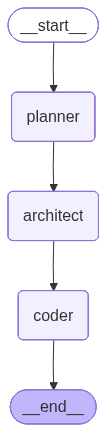

In [8]:
graph = StateGraph(AgentState)

graph.add_node("planner", planner_node)
graph.add_node("architect", architect_node)
graph.add_node("coder", coder_node)

graph.add_edge(START, "planner")
graph.add_edge("planner", "architect")
graph.add_edge("architect", "coder")
graph.add_edge("coder", END)

app = graph.compile()
app

In [9]:
user_input = "make one calculator app in python in a folder 'python_calculator_app'"

response = app.invoke({
    "user_prompt": user_input,
    "plan_with_architecture": ""
})

In [12]:
print(response["plan_with_architecture"])

{
  "name": "Python Calculator App",
  "description": "A simple command-line calculator application that performs basic arithmetic operations.",
  "techstack": ["Python"],
  "features": [
    "Addition, subtraction, multiplication, and division operations",
    "Handle user input for numbers and operations",
    "Display results clearly after each calculation",
    "Loop to allow multiple calculations without restarting",
    "Error handling for invalid inputs or division by zero"
  ]
}The error message you're seeing indicates that there's a mismatch between the expected input type (a string) and the actual input type (an integer). However, looking at your code, it seems like you're handling both string and integer inputs correctly. 

 Let's break down the code:

 1. You have a calculator that takes a sequence of operations and numbers. 
 2. The input is split into tokens and processed.
 3. You handle addition, subtraction, multiplication, and division.

 The error message suggests tha